In [1]:
# Mount Google Drive for persistent storage
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

# Create directories for results and figures on Google Drive
results_base_dir = '/content/drive/MyDrive/Colab_Notebooks/MNIST/Classification/'
figures_base_dir_original = '/content/drive/MyDrive/Colab_Notebooks/MNIST/Classification/Baseline_100p/'
import os
os.makedirs(results_base_dir, exist_ok=True)
os.makedirs(figures_base_dir_original, exist_ok=True)

# Set environment variables (optional, adjust if needed)
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".9"

# Load packages
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import csv

import sys
sys.path.append('/content/drive/MyDrive/Colab_Notebooks/MNIST/Classification/') # Adjust this path if needed

Mounted at /content/drive


In [2]:
csv_filename_orth = os.path.join(results_base_dir, 'C_orth_MNIST.csv')
csv_filename_eval = os.path.join(results_base_dir, 'C_eval_MNIST.csv')
csv_filename_zero = os.path.join(results_base_dir, 'C_zero_MNIST.csv')

number_of_simulations = 5

columns = [
    "P_training(%)", "Training Set", "Test set", "Epoch",
    "Total_Loss_Training", "BCE_Training", "KLD_Training", "LL_Training",
    "Total_Loss_Test", "BCE_Test", "KLD_Test", "LL_Test",
    "Train_accuracy", "Test_Accuracy_Original",
    "Accuracy_Original_Top_Generated_Bottom",
    "Accuracy_Generated_Top_Original_Bottom",
    "Accuracy_Processed_Top_Processed_Bottom",
    "AU1", "AU2"
]


In [3]:
def read_and_aggregate(csv_path, method_name, n_per_group):

    df = pd.read_csv(csv_path, header=None, skiprows=1)
    df.columns = columns
    # Chunk into groups and compute mean/std
    means, stds, pcts = [], [], []
    for i in range(0, len(df), n_per_group):
        block = df.iloc[i:i+n_per_group]
        if block.empty:
            continue
        pcts.append(block.iloc[0]["P_training(%)"])
        means.append(block.mean(axis=0))
        stds.append(block.std(axis=0))

    mean_df = pd.DataFrame(means).reset_index(drop=True)
    std_df  = pd.DataFrame(stds).reset_index(drop=True)

    # Preserve integer-like percentages and tag method
    mean_df["P_training(%)"] = pd.Series(pcts).astype(int)
    std_df["P_training(%)"]  = pd.Series(pcts).astype(int)
    mean_df["method"] = method_name
    std_df["method"]  = method_name

    return mean_df, std_df

In [4]:
mean_df_orth, std_df_orth = read_and_aggregate(csv_filename_orth, "orth", number_of_simulations)
mean_df_eval, std_df_eval = read_and_aggregate(csv_filename_eval, "eval", number_of_simulations)
mean_df_zero, std_df_zero = read_and_aggregate(csv_filename_zero, "zero", number_of_simulations)

In [ ]:
all_means, all_stds = [], []
all_means.append(mean_df_orth)
all_means.append(mean_df_eval)
all_means.append(mean_df_zero)
all_stds.append(std_df_orth)
all_stds.append(std_df_eval)
all_stds.append(std_df_zero)

long_mean = pd.concat(all_means, ignore_index=True)
long_std  = pd.concat(all_stds, ignore_index=True)

In [ ]:
def line_with_errorbars_by_method(long_mean, long_std, metric, title, ylabel, outfile):
    """Plot metric vs % training with a line per method; error bars from std."""
    plt.figure(figsize=(8, 5))

    for method, g in long_mean.groupby("method"):
        # ensure consistent ordering by percentage
        g_sorted = g.sort_values("P_training(%)")
        std_sorted = long_std[long_std["method"] == method].sort_values("P_training(%)")

        x = g_sorted["P_training(%)"].values
        y = g_sorted[metric].values
        yerr = std_sorted[metric].values if metric in std_sorted.columns else None

        plt.errorbar(x, y, yerr=yerr, fmt='-o', capsize=4, label=method)

    plt.xlabel("Training set used (%)")
    plt.ylabel(ylabel)
    #plt.title(title)
    plt.legend(title="Method")
    plt.tight_layout()
    plt.savefig(outfile, dpi=200)
    plt.close()

In [ ]:
line_with_errorbars_by_method(long_mean, long_std,
                                  metric="Test_Accuracy_Original",
                                  title="Test Accuracy (Original Views) vs Training %",
                                  ylabel="Accuracy",
                                  outfile=os.path.join(figures_base_dir_original, 'acc_original_vs_pct.png'))

line_with_errorbars_by_method(long_mean, long_std,
                                  metric="Accuracy_Original_Top_Generated_Bottom",
                                  title="Accuracy (Original Top / Generated Bottom) vs Training %",
                                  ylabel="Accuracy",
                                  outfile=os.path.join(figures_base_dir_original, 'acc_origTop_genBottom_vs_pct.png'))

line_with_errorbars_by_method(long_mean, long_std,
                                  metric="Accuracy_Processed_Top_Processed_Bottom",
                                  title="Accuracy (Processed Top & Bottom) vs Training %",
                                  ylabel="Accuracy",
                                  outfile=os.path.join(figures_base_dir_original, 'acc_processed_vs_pct.png'))

In [ ]:
line_with_errorbars_by_method(long_mean, long_std,
                                  metric="BCE_Test",
                                  title="BCE_Test vs Training %",
                                  ylabel="BCE_Test",
                                  outfile=os.path.join(figures_base_dir_original, "bce_vs_pct.png"))

line_with_errorbars_by_method(long_mean, long_std,
                                  metric="LL_Test",
                                  title="Log-Likelihood (Test) vs Training %",
                                  ylabel="LL_Test",
                                  outfile=os.path.join(figures_base_dir_original, "ll_vs_pct.png"))

line_with_errorbars_by_method(long_mean, long_std,
                                  metric="KLD_Test",
                                  title="KLD_Test vs Training %",
                                  ylabel="KLD_Test",
                                  outfile=os.path.join(figures_base_dir_original, "kld_vs_pct.png"))

In [ ]:
def penalty_vs_pct(long_mean, long_std, acc_col, title, outfile):
    """
    Plot 'imputation penalty' vs % training for each method using each method's
    own 100% original baseline. Penalty = baseline_100%_original - accuracy(metric).
    Error bars combine baseline and metric std in quadrature.
    """
    plt.figure(figsize=(8, 5))

    for method, g in long_mean.groupby("method"):
        g_std = long_std[long_std["method"] == method]

        # find baseline at 100%
        m100 = g[g["P_training(%)"] == 100]
        s100 = g_std[g_std["P_training(%)"] == 100]
        if m100.empty or s100.empty:
            # if missing 100% row, skip
            continue

        base_mean = float(m100["Test_Accuracy_Original"].values[0])
        base_sd   = float(s100["Test_Accuracy_Original"].values[0])

        g_sorted = g.sort_values("P_training(%)")
        s_sorted = g_std.sort_values("P_training(%)")

        x = g_sorted["P_training(%)"].values
        y = base_mean - g_sorted[acc_col].values
        yerr = np.sqrt(base_sd**2 + (s_sorted[acc_col].values)**2)

        plt.errorbar(x, y, yerr=yerr, fmt='-o', capsize=4, label=method)

    plt.xlabel("Training set used (%)")
    plt.ylabel("Accuracy drop vs 100% original")
    #plt.title(title + " (baseline per method = 100% Test_Accuracy_Original)")
    plt.legend(title="Method")
    plt.tight_layout()
    plt.savefig(outfile, dpi=200)
    plt.close()

In [ ]:
penalty_vs_pct(long_mean, long_std,
                   acc_col="Accuracy_Original_Top_Generated_Bottom",
                   title="Imputation penalty (Generated Bottom)",
                   outfile=os.path.join(figures_base_dir_original, "penalty_generated_vs_pct.png"))

penalty_vs_pct(long_mean, long_std,
                   acc_col="Accuracy_Processed_Top_Processed_Bottom",
                   title="Imputation penalty (Processed)",
                   outfile=os.path.join(figures_base_dir_original, "penalty_processed_vs_pct.png"))

In [ ]:
def latent_capacity_scatter(long_mean, long_std, au_col, acc_col, outfile):
    """
    Scatter: AUx vs accuracy, colored by method (matplotlib default colors).
    Points annotated with % training for readability (avoids specifying colors by %).
    Adds a simple linear fit per method if possible.
    """
    plt.figure(figsize=(7, 5))

    for method, g in long_mean.groupby("method"):
        g_sorted = g.sort_values("P_training(%)")

        xs = g_sorted[au_col].values
        ys = g_sorted[acc_col].values
        plt.scatter(xs, ys, label=method, edgecolors='k')

        # annotate with percent labels
        for _, row in g_sorted.iterrows():
            plt.annotate(f"{int(row['P_training(%)'])}%", (row[au_col], row[acc_col]),
                         textcoords="offset points", xytext=(5,5), fontsize=8)

        # optional linear fit if variance exists
        if len(xs) >= 2 and np.std(xs) > 0:
            m, b = np.polyfit(xs, ys, 1)
            xline = np.linspace(xs.min(), xs.max(), 100)
            plt.plot(xline, m*xline + b, linestyle='--')

    plt.xlabel(au_col)
    plt.ylabel(acc_col)
    #plt.title(f"{acc_col} vs {au_col}")
    plt.legend(title="Method")
    plt.tight_layout()
    plt.savefig(outfile, dpi=200)
    plt.close()

In [ ]:
latent_capacity_scatter(long_mean, long_std,
                            au_col="AU1",
                            acc_col="Accuracy_Processed_Top_Processed_Bottom",
                            outfile=os.path.join(figures_base_dir_original, "AU1_vs_acc_processed.png"))

latent_capacity_scatter(long_mean, long_std,
                            au_col="AU2",
                            acc_col="Accuracy_Processed_Top_Processed_Bottom",
                            outfile=os.path.join(figures_base_dir_original, "AU2_vs_acc_processed.png"))

In [ ]:
def latent_capacity_scatter_sum(long_mean, long_std,
                                au_col,            # "AU1", "AU2", or "AU1+AU2" / "AU_SUM" / "AU1_plus_AU2"
                                acc_col,           # e.g. "Accuracy_Processed_Top_Processed_Bottom"
                                outfile=None,      # filepath or None to just show()
                                annotate_pct=True,
                                fit_line=True,
                                show_errorbars=True):
    """
    Scatter: AUx (or AU1+AU2) vs accuracy, colored by method (matplotlib defaults).
    Points annotated with % training. Optional linear fit and error bars.
    Expects columns: "P_training(%)", "method", "AU1", "AU2", acc_col in long_mean/long_std.
    """
    plt.figure(figsize=(7, 5))

    # Normalize alias for AU sum
    use_sum = au_col in {"AU_SUM", "AU1+AU2", "AU1_plus_AU2"}

    for method, g_mean in long_mean.groupby("method"):
        g_mean = g_mean.sort_values("P_training(%)")
        g_std  = long_std[long_std["method"] == method].sort_values("P_training(%)")

        if use_sum:
            xs = (g_mean["AU1"].values + g_mean["AU2"].values).astype(float)
            # x-error via quadrature if requested
            if show_errorbars:
                xerr = np.sqrt(g_std["AU1"].values.astype(float)**2 +
                               g_std["AU2"].values.astype(float)**2)
            x_label = "AU1+AU2"
        else:
            xs = g_mean[au_col].values.astype(float)
            xerr = g_std[au_col].values.astype(float) if show_errorbars and (au_col in g_std.columns) else None
            x_label = au_col

        ys = g_mean[acc_col].values.astype(float)
        yerr = g_std[acc_col].values.astype(float) if show_errorbars and (acc_col in g_std.columns) else None

        # scatter points (default colors)
        plt.scatter(xs, ys, label=method, edgecolors='k')

        # optional error bars
        #if show_errorbars:
        #    plt.errorbar(xs, ys, xerr=xerr, yerr=yerr, fmt='none', ecolor='gray', alpha=0.6, capsize=3)

        # annotate with % training
        if annotate_pct:
            for _, row in g_mean.iterrows():
                xv = (float(row["AU1"] + row["AU2"])) if use_sum else float(row[au_col])
                yv = float(row[acc_col])
                plt.annotate(f"{int(row['P_training(%)'])}%", (xv, yv),
                             textcoords="offset points", xytext=(5, 5), fontsize=8)

        # optional linear fit
        if fit_line and len(xs) >= 2 and np.std(xs) > 0:
            m, b = np.polyfit(xs, ys, 1)
            xline = np.linspace(xs.min(), xs.max(), 100)
            plt.plot(xline, m * xline + b, linestyle='--')

    plt.xlabel(x_label)
    plt.ylabel(acc_col)
    #plt.title(f"{acc_col} vs {x_label}")
    plt.legend(title="Method")
    plt.tight_layout()

    if outfile:
        plt.savefig(outfile, dpi=200)
        plt.close()
    else:
        plt.show()

In [ ]:
latent_capacity_scatter_sum(long_mean, long_std,
                        au_col="AU1+AU2",
                        acc_col="Accuracy_Processed_Top_Processed_Bottom",
                        outfile=os.path.join(figures_base_dir_original,"AU1plusAU2_vs_acc_processed.png"))

<>:48: SyntaxWarning: invalid escape sequence '\m'
<>:48: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipython-input-2710325282.py:48: SyntaxWarning: invalid escape sequence '\m'
  ax.set_title("Classifier Accuracies by View Combination vs Training Percentage for $\mathbf{C}^T\mathbf{C}=\mathbf{C}\mathbf{C}^T=\mathbf{I}$")
/tmp/ipython-input-2710325282.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  viridis = plt.cm.get_cmap('viridis', max(nP, 3))   # at least 3, but 4 if you have 4 percentages


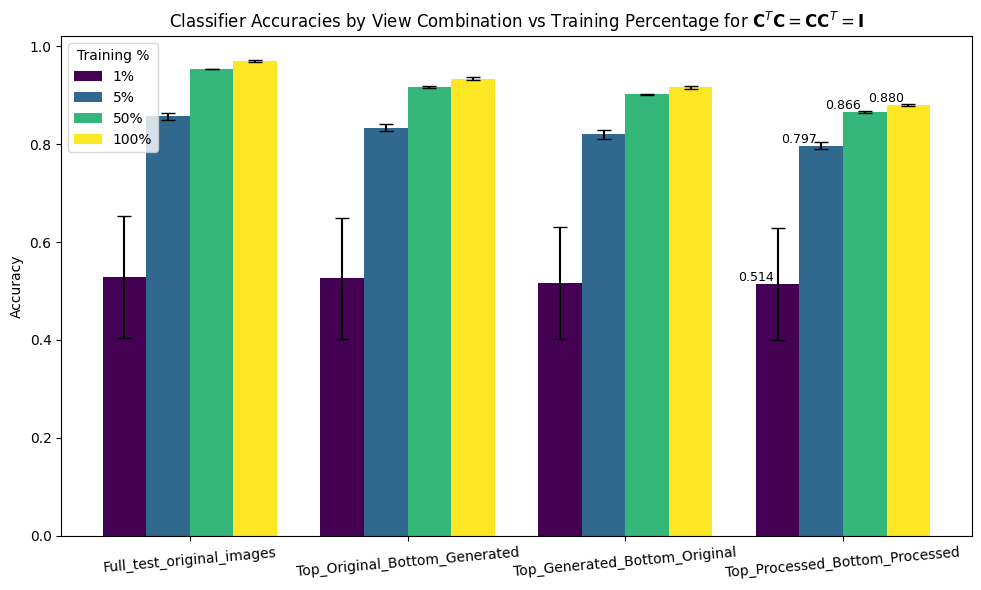

In [7]:
percentages = sorted([int(p) for p in mean_df_orth["P_training(%)"]])
# --- 3) Build grouped bar chart: x-axis = view combinations; bars = percentages ---
view_cols = [
    "Test_Accuracy_Original",
    "Accuracy_Original_Top_Generated_Bottom",
    "Accuracy_Generated_Top_Original_Bottom",
    "Accuracy_Processed_Top_Processed_Bottom"
]

x = np.arange(len(view_cols))                  # positions for the three view combos
nP = len(percentages)
bar_width = 0.8 / nP                           # fit all % bars within each category

# Choose your processed case (the "fourth case" you mentioned)
processed_col = "Accuracy_Processed_Top_Processed_Bottom"
proc_idx = view_cols.index(processed_col)  # index within view_cols

# Use the same viridis style, but sized to however many percentages you have
viridis = plt.cm.get_cmap('viridis', max(nP, 3))   # at least 3, but 4 if you have 4 percentages
colors = viridis(np.linspace(0, 1, nP))            # or use jnp.linspace if you prefer

fig, ax = plt.subplots(figsize=(10, 6))

for i, p in enumerate(percentages):
    y = [float(mean_df_orth.loc[mean_df_orth["P_training(%)"] == p, col].values[0])
         for col in view_cols]
    yerr = [float(std_df_orth.loc[std_df_orth["P_training(%)"] == p, col].values[0])
            for col in view_cols]

    offset = (i - (nP - 1) / 2) * bar_width
    bars = ax.bar(x + offset, y, yerr=yerr, capsize=5, width=bar_width, label=f"{p}%", color=colors[i])

    proc_bar = bars[proc_idx]
    height = proc_bar.get_height()
    ax.text(proc_bar.get_x(), height,
            f"{height:.3f}", ha="center", va="bottom", fontsize=9)

ax.set_xticks(x)

index_labels_plot2 = [
    "Full_test_original_images",
    "Top_Original_Bottom_Generated",
    "Top_Generated_Bottom_Original",
    "Top_Processed_Bottom_Processed"
]
ax.set_xticklabels(index_labels_plot2, rotation=5, ha='center')
ax.set_ylabel("Accuracy")
ax.set_title("Classifier Accuracies by View Combination vs Training Percentage for $\mathbf{C}^T\mathbf{C}=\mathbf{C}\mathbf{C}^T=\mathbf{I}$")
ax.legend(title="Training %")
plt.tight_layout()
plt.savefig(os.path.join(figures_base_dir_original, 'accuracy_comparison_orth.png'))
plt.show()

<>:48: SyntaxWarning: invalid escape sequence '\s'
<>:48: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-3255425587.py:48: SyntaxWarning: invalid escape sequence '\s'
  ax.set_title("Classifier Accuracies by View Combination vs Training Percentage for $\sigma_1(\mathbf{C})<1$")
/tmp/ipython-input-3255425587.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  viridis = plt.cm.get_cmap('viridis', max(nP, 3))   # at least 3, but 4 if you have 4 percentages


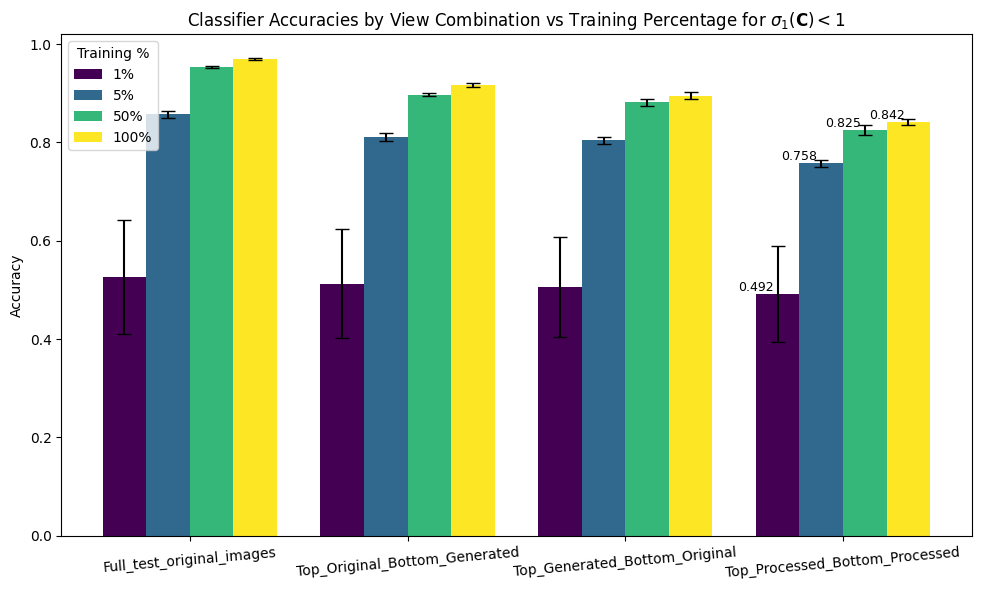

In [8]:
percentages = sorted([int(p) for p in mean_df_eval["P_training(%)"]])
# --- 3) Build grouped bar chart: x-axis = view combinations; bars = percentages ---
view_cols = [
    "Test_Accuracy_Original",
    "Accuracy_Original_Top_Generated_Bottom",
    "Accuracy_Generated_Top_Original_Bottom",
    "Accuracy_Processed_Top_Processed_Bottom"
]

x = np.arange(len(view_cols))                  # positions for the three view combos
nP = len(percentages)
bar_width = 0.8 / nP                           # fit all % bars within each category

# Choose your processed case (the "fourth case" you mentioned)
processed_col = "Accuracy_Processed_Top_Processed_Bottom"
proc_idx = view_cols.index(processed_col)  # index within view_cols

# Use the same viridis style, but sized to however many percentages you have
viridis = plt.cm.get_cmap('viridis', max(nP, 3))   # at least 3, but 4 if you have 4 percentages
colors = viridis(np.linspace(0, 1, nP))            # or use jnp.linspace if you prefer

fig, ax = plt.subplots(figsize=(10, 6))

for i, p in enumerate(percentages):
    y = [float(mean_df_eval.loc[mean_df_eval["P_training(%)"] == p, col].values[0])
         for col in view_cols]
    yerr = [float(std_df_eval.loc[std_df_eval["P_training(%)"] == p, col].values[0])
            for col in view_cols]

    offset = (i - (nP - 1) / 2) * bar_width
    bars = ax.bar(x + offset, y, yerr=yerr, capsize=5, width=bar_width, label=f"{p}%", color=colors[i])

    proc_bar = bars[proc_idx]
    height = proc_bar.get_height()
    ax.text(proc_bar.get_x(), height,
            f"{height:.3f}", ha="center", va="bottom", fontsize=9)

ax.set_xticks(x)

index_labels_plot2 = [
    "Full_test_original_images",
    "Top_Original_Bottom_Generated",
    "Top_Generated_Bottom_Original",
    "Top_Processed_Bottom_Processed"
]
ax.set_xticklabels(index_labels_plot2, rotation=5, ha='center')
ax.set_ylabel("Accuracy")
ax.set_title("Classifier Accuracies by View Combination vs Training Percentage for $\sigma_1(\mathbf{C})<1$")
ax.legend(title="Training %")
plt.tight_layout()
plt.savefig(os.path.join(figures_base_dir_original, 'accuracy_comparison_eval.png'))
plt.show()